# Artificial Intelligence Nanodegree

## Project: Dog Breed Identification App using CNNs and PyTorch


---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.

### Extra Challenge (PyTorch)
As an extra challenge, I decided to build this project in PyTorch. The original Udacity project was done in Keras. This is my very first exposure to PyTorch, so please bear with me. Most of the PyTorch specific code below was written using [this tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) as a guide. I will post some lessons learned in the README.md.

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 1](#step1): Import & Explore Data
* [Step 2](#step2): Generate Datasets
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 4](#step4): Inference: Use Model to Make Predictions
* [Step 5](#step5): Incorporate Model into Human-Dog Detection Algorithm

---

In [375]:
import copy
from glob import glob
from io import open
import json
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os, random
from PIL import Image
import requests
import shutil
import time

import torch
from torch.autograd import Variable
import torch.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

plt.ion()   # interactive mode

%matplotlib inline

---
<a id='step1'></a>
## Step 1:  Import and Explore Data

In the code cell below, we import a dataset of dog images. See the [project instructions page](https://github.com/tommytracey/aind-dog-project#project-instructions) for links to download the data files. Once setup, our images directory should looks like this:

```
project_folder
__dogImages
____train
______class_breed
________dog_img_a.jpg
________dog_img_b.jpg
____val
______class_breed
________dog_img_c.jpg
________dog_img_d.jpg
____test
______class_breed
________dog_img_e.jpg
________dog_img_f.jpg
```
__NOTE:__ The validation subdirectory must be renamed from "valid" to "val" in order to work with the PyTorch dataloader, specifically the `datasets.ImageFolder` method.

Now that our `dogImages` directory is setup, we should familiarize ourself with the data. I did this as part of a separate notebook, [dog-breed-data-exploration.ipynb](https://github.com/tommytracey/aind-dog-project/blob/master/dog-breed-data-exploration.ipynb).

---
<a id='step2'></a>
## Step 2:  Create Datasets

### Normalization and Augmentation
In the cell below, we setup our `data_transforms`, where we define the normalization and augmentation steps we want to perform on the data. Note that augmentation (beyond resizing) is only performed on the training set. 

In [376]:
# All images are resized to 224x224 and normalized
# Only training images receive further augmentation

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(1.0, 1.1), shear=5, resample=False, fillcolor=0),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)], p=0.5),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),    
}


Device: cuda:0


### Generate datasets for Training, Validation, and Testing


Now we'll iterate through the data and apply the transforms outlined above. 

One thing to notice here is the way the class label data is automatically derived using the `torchvision.datasets.ImageFolder` method. This is a very handy tool. One nice feature of this method is that we don't need to one-hot encode our labels. It builds an index of class labels from the names of the subdirectories in the train/val/test folders. So you don't need to manually import the classes. 

However, note that the class IDs are automatically assigned by PyTorch and therefore might be different than the original class IDs that were assigned to each dog breed as part of the original project in Keras. Rather than try to remove these old class IDs from the subdirectory folder names, I decided to simply ignore them and just rely on the index generated through Torchvision.

In [ ]:
data_dir = 'dogImages'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
n_classes = len(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

In [357]:
print(f"No. of Training Records: {dataset_sizes['train']}")
print(f"No. of Validation Records: {dataset_sizes['val']}")
print(f"No. of Testing Records: {dataset_sizes['test']}")

No. of Training Records: 6680
No. of Validation Records: 835
No. of Testing Records: 836


In [348]:
# Preview the set of class labels (i.e. dog breeds) 
# -- again, note that the old class IDs are included in the labels. This is a carryover from the original project,
# -- which was setup for Keras. We'll leave the IDs for now and split them out later during the inference step.

print(f"No. of Classes: {n_classes}")
class_names

No. of Classes: 133


['001.Affenpinscher',
 '002.Afghan_hound',
 '003.Airedale_terrier',
 '004.Akita',
 '005.Alaskan_malamute',
 '006.American_eskimo_dog',
 '007.American_foxhound',
 '008.American_staffordshire_terrier',
 '009.American_water_spaniel',
 '010.Anatolian_shepherd_dog',
 '011.Australian_cattle_dog',
 '012.Australian_shepherd',
 '013.Australian_terrier',
 '014.Basenji',
 '015.Basset_hound',
 '016.Beagle',
 '017.Bearded_collie',
 '018.Beauceron',
 '019.Bedlington_terrier',
 '020.Belgian_malinois',
 '021.Belgian_sheepdog',
 '022.Belgian_tervuren',
 '023.Bernese_mountain_dog',
 '024.Bichon_frise',
 '025.Black_and_tan_coonhound',
 '026.Black_russian_terrier',
 '027.Bloodhound',
 '028.Bluetick_coonhound',
 '029.Border_collie',
 '030.Border_terrier',
 '031.Borzoi',
 '032.Boston_terrier',
 '033.Bouvier_des_flandres',
 '034.Boxer',
 '035.Boykin_spaniel',
 '036.Briard',
 '037.Brittany',
 '038.Brussels_griffon',
 '039.Bull_terrier',
 '040.Bulldog',
 '041.Bullmastiff',
 '042.Cairn_terrier',
 '043.Canaan_do

In [385]:
# Preview a record (input, label) from the training set. 
# -- Image pixel values should be normalized. Label value should be an integer between 0 and 133.

dataloaders['train'].dataset[1500]

(tensor([[[-0.2471, -0.2314, -0.2078,  ..., -0.9294, -0.9294, -0.9294],
          [-0.2392, -0.2078, -0.1765,  ..., -0.9294, -0.9294, -0.9294],
          [-0.2235, -0.1765, -0.1451,  ..., -0.9294, -0.9294, -0.9294],
          ...,
          [ 0.2392,  0.2235,  0.2157,  ...,  0.2235,  0.2235,  0.2392],
          [ 0.2627,  0.2392,  0.2314,  ...,  0.2392,  0.2392,  0.2392],
          [ 0.2706,  0.2549,  0.2314,  ...,  0.3412,  0.3333,  0.3176]],
 
         [[-0.3255, -0.2784, -0.2549,  ..., -0.9294, -0.9294, -0.9294],
          [-0.3255, -0.2706, -0.2314,  ..., -0.9294, -0.9294, -0.9294],
          [-0.3098, -0.2392, -0.2078,  ..., -0.9294, -0.9294, -0.9294],
          ...,
          [-0.1608, -0.1843, -0.2078,  ...,  0.2235,  0.2235,  0.2235],
          [-0.1373, -0.1608, -0.1686,  ...,  0.2471,  0.2392,  0.2392],
          [-0.1294, -0.1451, -0.1608,  ...,  0.3412,  0.3333,  0.3255]],
 
         [[-0.3804, -0.3725, -0.3569,  ..., -0.9294, -0.9294, -0.9294],
          [-0.3725, -0.3569,

### Visualize Image Transformations
Let’s visualize a few training images to make sure the data augmentations are in-line with our expectations.

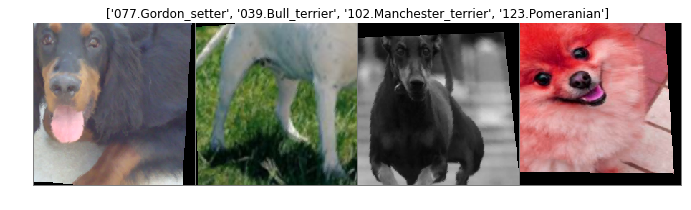

In [54]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    fig = plt.figure(figsize=(12,3))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

We can observe the various perturbations in the images above. To the naked eye, they seem to make sense. We see different shifts in translation, cropping, rotation, brightness, color, etc. However, none of the transformations overly distort the image to the point where the dog breed can't be recognized. These augmentations should help our model generalize and reduce overfitting. I love how easily this can be done in PyTorch.

---
<a id='step3'></a>
## Step 3:  Create a CNN to Classify Dog Breeds (using Transfer Learning)
Now we use transfer learning to create a CNN that can identify dog breeds from images. The goal for the Udacity project is to attain at least 60% accuracy on the test set.

### Training Loop

In [234]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} | Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), "saved_models/resnet18_model_{}.ckpt".format(epoch+1))
                print("Checkpoint saved")                

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

### Load Pre-trained Model and Replace Last Fully Connected Layer
You can choose from a handful of pre-trained models in PyTorch. The complete list is available [here](https://pytorch.org/docs/stable/torchvision/models.html). For simplicity, I chose ResNet18 because that's what's used in the [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#finetuning-the-convnet).

**NOTE:**
I'm just following the tutorial code here. I expected to see a softmax activation as part of the final layer (as is commonly done in Keras). This would give us a probabality distribution that indidcates the model's confidence of the predicted breeds for a given input image. But, I wasn't able to get softmax working at this point, and ultimately decided to apply it to the outputs during inference.

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, n_classes)

model_ft = model_ft.to(device)

### Setup Optimization, Regularization, and Loss Functions

In [236]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimization + learning rate. Note that all parameters are being optimized.
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Regularization. Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [237]:
# Fix for cuda error resulting from truncated images
# https://stackoverflow.com/a/23575424/7434289

from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [238]:
# Run the training loop

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 1/15
----------
train Loss: 3.8061 Acc: 0.1509
val Loss: 1.5964 Acc: 0.5581
Checkpoint saved

Epoch 2/15
----------
train Loss: 2.8379 Acc: 0.3033
val Loss: 1.1827 Acc: 0.6575
Checkpoint saved

Epoch 3/15
----------
train Loss: 2.5885 Acc: 0.3557
val Loss: 1.2927 Acc: 0.6311

Epoch 4/15
----------
train Loss: 2.4078 Acc: 0.3907
val Loss: 1.1575 Acc: 0.6587
Checkpoint saved

Epoch 5/15
----------
train Loss: 2.3119 Acc: 0.4105
val Loss: 1.0104 Acc: 0.7198
Checkpoint saved

Epoch 6/15
----------
train Loss: 2.1806 Acc: 0.4424
val Loss: 1.1142 Acc: 0.6934

Epoch 7/15
----------
train Loss: 2.1460 Acc: 0.4654
val Loss: 1.0887 Acc: 0.7066

Epoch 8/15
----------
train Loss: 1.7158 Acc: 0.5608
val Loss: 0.6142 Acc: 0.8072
Checkpoint saved

Epoch 9/15
----------
train Loss: 1.6028 Acc: 0.5882
val Loss: 0.6023 Acc: 0.8012

Epoch 10/15
----------
train Loss: 1.5486 Acc: 0.6081
val Loss: 0.5558 Acc: 0.8096
Checkpoint saved

Epoch 11/15
----------
train Loss: 1.4863 Acc: 0.6199
val Loss: 0.5

In [366]:
# Run the training loop again to eek out a little more accuracy

model_ft = model_ft.to(device)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 1/5
----------
train Loss: 1.3585 Acc: 0.6528
val Loss: 0.5726 Acc: 0.8156
Checkpoint saved

Epoch 2/5
----------
train Loss: 1.3745 Acc: 0.6567
val Loss: 0.5469 Acc: 0.8168
Checkpoint saved

Epoch 3/5
----------
train Loss: 1.4085 Acc: 0.6394
val Loss: 0.5508 Acc: 0.8168

Epoch 4/5
----------
train Loss: 1.3863 Acc: 0.6451
val Loss: 0.5247 Acc: 0.8240
Checkpoint saved

Epoch 5/5
----------
train Loss: 1.3958 Acc: 0.6478
val Loss: 0.5606 Acc: 0.8228

Training complete in 7m 37s
Best val Acc: 0.823952


### Visualize Model Results
Before going any further, let's visualize a sample of the model output to make sure the predictions make sense.

In [342]:
def visualize_model(model, num_images=3):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(16,4))
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
#             inputs = inputs.to(device)   # occasionally commented this out to resolve device mismatch error
#             labels = labels.to(device)   # occasionally commented this out to resolve device mismatch error

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
        
            for j in range(inputs.size()[0]):
                images_so_far += 1
                inp = inputs.cpu().data[j]
                inp = inp.numpy().transpose((1, 2, 0))
                mean = np.array([0.5, 0.5, 0.5])
                std = np.array([0.5, 0.5, 0.5])
                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)

                ax = fig.add_subplot(1, 3, images_so_far)
                ax.imshow(inp.squeeze(), cmap="gray", interpolation='nearest')        
                plt.title('predicted: {}'.format(class_names[preds[j]]))
                plt.axis('off')

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
            plt.show()
        model.train(mode=was_training)

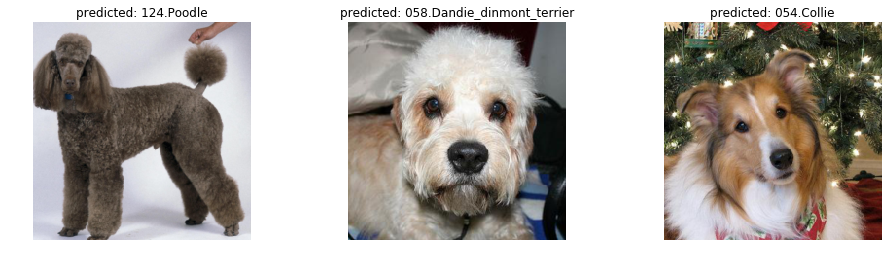

In [343]:
visualize_model(model_ft)

### Test Accuracy

In [360]:
def test_acc(test_set, model):
    '''Calculates accuracy. Takes as input a PyTorch dataloader object containing images and labels.'''
    model.eval()
    test_acc = 0.0
    running_corrects = 0

    # Iterate over data
    for inputs, labels in test_set:
#         inputs = inputs.to(device)   # occasionally commented this out to resolve device mismatch error
#         labels = labels.to(device)   # occasionally commented this out to resolve device mismatch error 
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    test_acc = running_corrects.double() / len(test_set.dataset)

    print('Acc: {:.2f}%'.format(test_acc*100))

    return test_acc

In [361]:
test_acc(dataloaders['test'], model_ft)

Acc: 81.58%


tensor(0.8158, dtype=torch.float64)

Although we won't be winning any Kaggle competitions, our accuracy still looks good!

---
<a id='step4'></a>
## Step 4:  Inference &mdash; Use Model to Make Predictions
In this step, we use the best-performing version of our model to make dog breed predictions. Normally you'd use completely new images for this step, but I decided to use the tet images in order to save time. We'll perform true inference on new images in the final step.

In [367]:
# Instantiate model, load weights, and set model to evaluation mode

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, n_classes)

model_ft = model_ft.to(device)

checkpoint = torch.load('saved_models/resnet18_model_4.ckpt')
model_ft.load_state_dict(checkpoint)
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

### Make Predictions
This function takes an image path and returns the top 3 predicted breeds and the associated softmax probabilities. 

In [368]:
def predict_breed(image_path):
    '''Predicts the top 3 most likely breeds for a given image.'''
    
    image = Image.open(image_path)

    # Define transformations for the image
    transformation = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    # Preprocess the image
    image_tensor = transformation(image).float()

    # Add an extra batch dimension since pytorch treats all images as batches
    image_tensor = image_tensor.unsqueeze_(0)

    if torch.cuda.is_available():
        image_tensor.cuda()

    # Turn the input into a Variable
    input = Variable(image_tensor)

    # Return the top predictions and confidence scores
    output = model(input)
    softmax = nn.Softmax(dim=1)
    preds = softmax(output)
    top_preds = torch.topk(preds, 3)
    pred_breeds = [class_names[i] for i in top_preds[1][0]]
    confidence = top_preds[0][0]
    
    return pred_breeds, confidence

In [369]:
predict_breed('dogImages/test/047.Chesapeake_bay_retriever/Chesapeake_bay_retriever_03361.jpg')

(['047.Chesapeake_bay_retriever',
  '060.Dogue_de_bordeaux',
  '096.Labrador_retriever'],
 tensor([ 0.9812,  0.0073,  0.0052]))

The prediction was correct with 98% certainty!

### Display Predictions
Now let's look at dog breed predictions for a set of test images.

In [370]:
# Create list of test image paths

test_img_paths = sorted(glob('dogImages/test/*/*'))

In [371]:
# Shuffle the list and display first few rows

np.random.shuffle(test_img_paths)
test_img_paths[0:5]

['dogImages/test/108.Norwegian_buhund/Norwegian_buhund_07111.jpg',
 'dogImages/test/049.Chinese_crested/Chinese_crested_03524.jpg',
 'dogImages/test/106.Newfoundland/Newfoundland_07007.jpg',
 'dogImages/test/062.English_setter/English_setter_04398.jpg',
 'dogImages/test/103.Mastiff/Mastiff_06836.jpg']

In [372]:
def display_predictions(img_paths):

    for img_path in img_paths:   
        print("What's up DOG?!")
        
        # display test image
        _, ax = plt.subplots()
        img = mpimg.imread(img_path)
        _ = ax.imshow(img)
        plt.axis('off')
        plt.show()

        # extract breed from image path
        actual_breed = img_path.split('/')[2].split('.')[1]
        print(f"Actual Breed: {actual_breed}\n")
        
        # display breeds and confidence scores
        breeds, confidence = predict_breed(img_path)
        predictions = ""
        for breed, conf in zip(breeds, confidence):
            if conf > 0.005:
                predictions += f"  - {breed.split('.')[1]} ({(conf*100):.0f}%)\n"
        print(f"Predicted Breed (confidence):\n{predictions}")
        
        # display sample of matching breed images
        fig = plt.figure(figsize=(16,4)) 
        for i, breed in enumerate(breeds):
            subdir = '/'.join(['dogImages/val', breed])
            file = random.choice(os.listdir(subdir))
            path = '/'.join([subdir, file])
            img = mpimg.imread(path)
            ax = fig.add_subplot(1,3,i+1)
            ax.imshow(img.squeeze(), cmap="gray", interpolation='nearest')
            plt.title(breed.split('.')[1])
            plt.axis('off')
        plt.show()
        print("\n"*3)  

What's up DOG?!


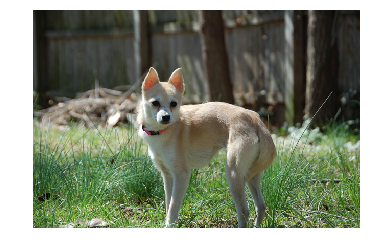

Actual Breed: Norwegian_buhund

Predicted Breed (confidence):
  - Canaan_dog (76%)
  - Norwegian_buhund (17%)
  - Norwegian_lundehund (2%)



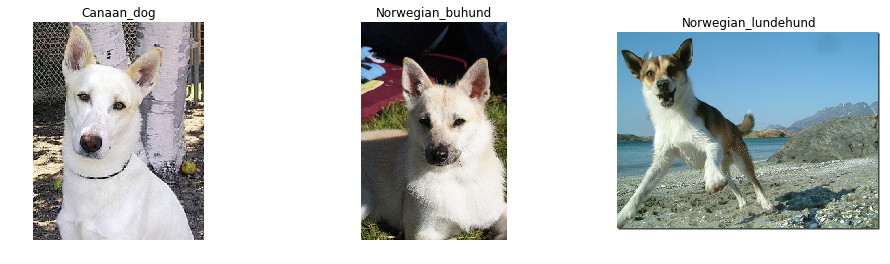





What's up DOG?!


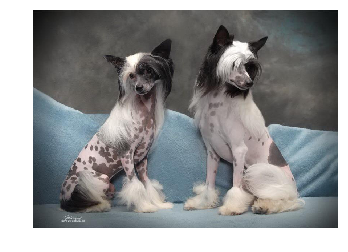

Actual Breed: Chinese_crested

Predicted Breed (confidence):
  - Chinese_crested (80%)
  - Lowchen (6%)
  - Maltese (3%)



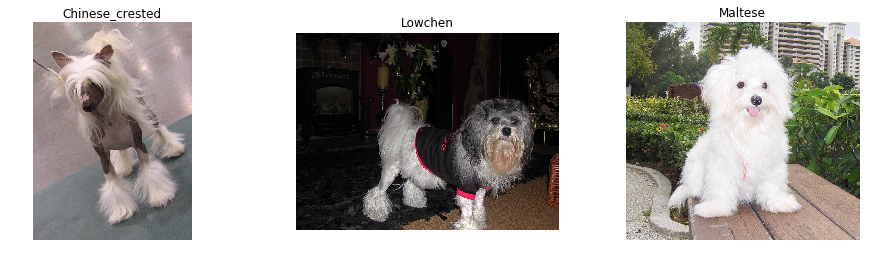





What's up DOG?!


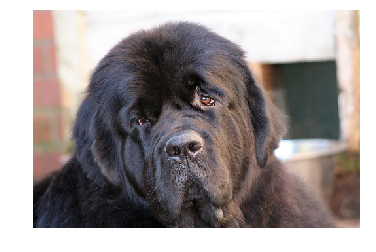

Actual Breed: Newfoundland

Predicted Breed (confidence):
  - Newfoundland (100%)



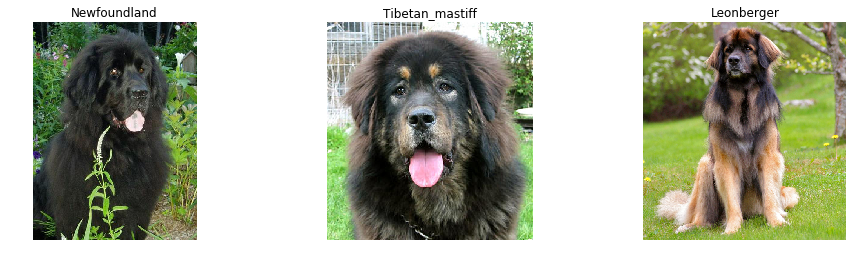





What's up DOG?!


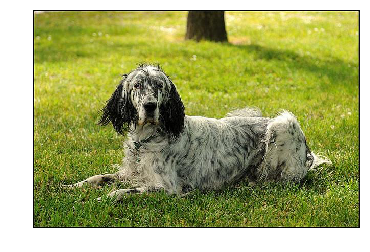

Actual Breed: English_setter

Predicted Breed (confidence):
  - English_setter (56%)
  - Neapolitan_mastiff (29%)
  - Irish_wolfhound (4%)



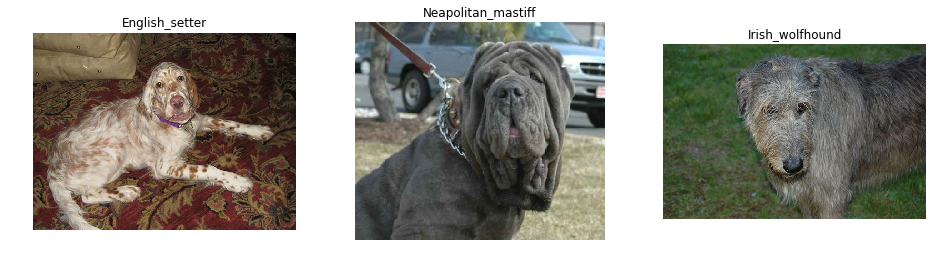





What's up DOG?!


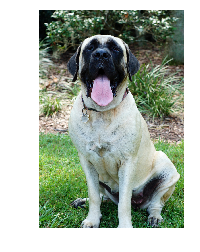

Actual Breed: Mastiff

Predicted Breed (confidence):
  - Mastiff (100%)



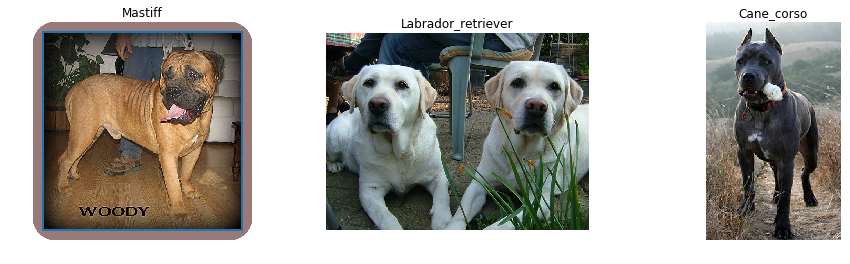





What's up DOG?!


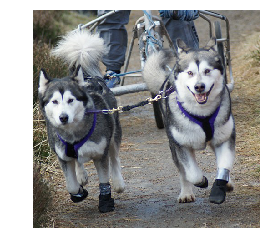

Actual Breed: Alaskan_malamute

Predicted Breed (confidence):
  - Alaskan_malamute (100%)



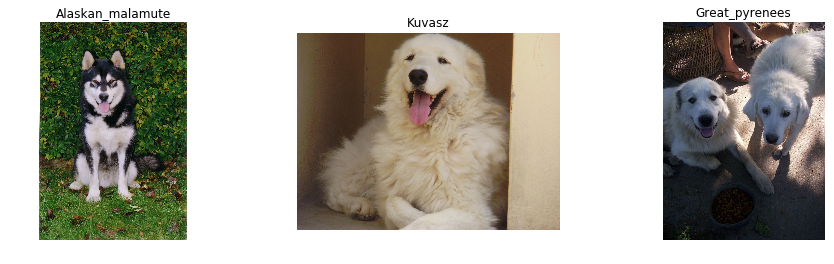





What's up DOG?!


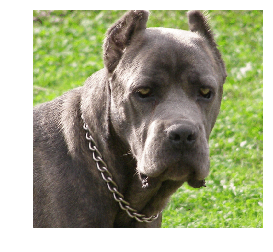

Actual Breed: Cane_corso

Predicted Breed (confidence):
  - Cane_corso (95%)
  - Neapolitan_mastiff (4%)
  - American_staffordshire_terrier (1%)



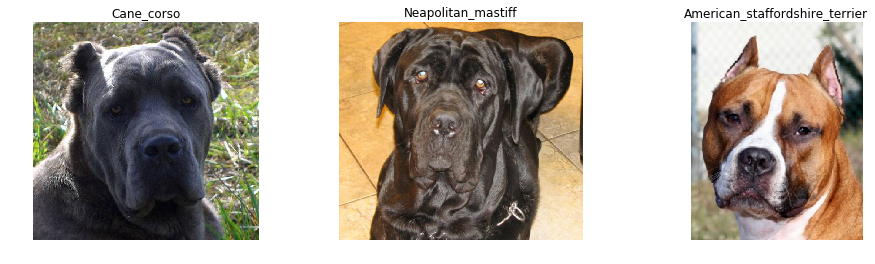





What's up DOG?!


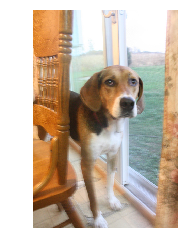

Actual Breed: American_foxhound

Predicted Breed (confidence):
  - Beagle (76%)
  - American_foxhound (19%)
  - Labrador_retriever (3%)



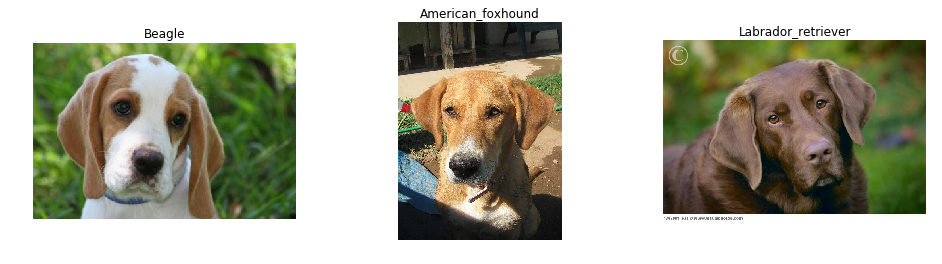





What's up DOG?!


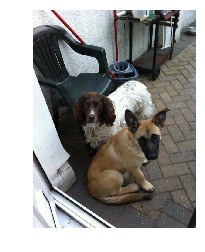

Actual Breed: English_springer_spaniel

Predicted Breed (confidence):
  - Canaan_dog (11%)
  - Norwegian_buhund (11%)
  - Akita (10%)



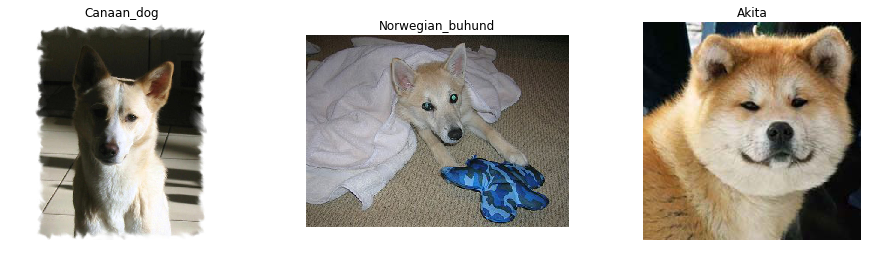





What's up DOG?!


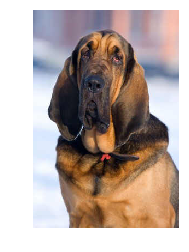

Actual Breed: Bloodhound

Predicted Breed (confidence):
  - Bloodhound (100%)



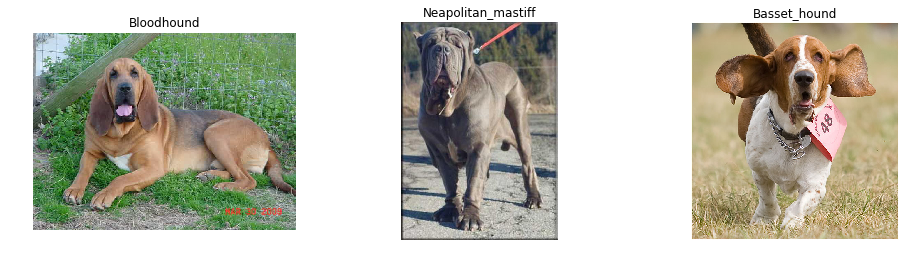





What's up DOG?!


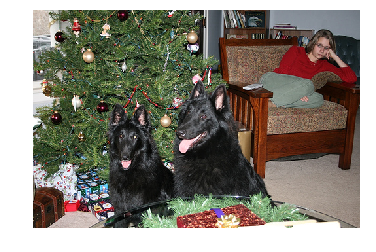

Actual Breed: Belgian_sheepdog

Predicted Breed (confidence):
  - Belgian_sheepdog (88%)
  - Poodle (7%)
  - Newfoundland (2%)



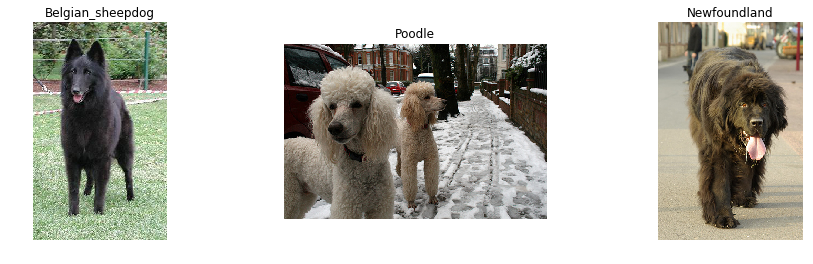





What's up DOG?!


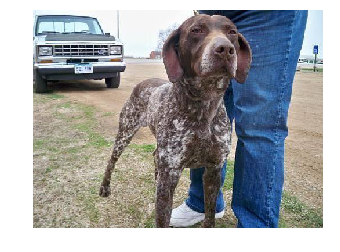

Actual Breed: German_shorthaired_pointer

Predicted Breed (confidence):
  - German_shorthaired_pointer (81%)
  - Chesapeake_bay_retriever (7%)
  - Mastiff (7%)



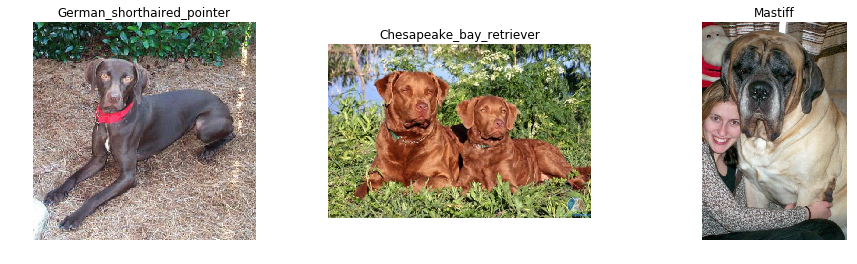





What's up DOG?!


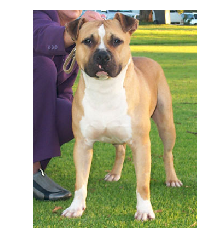

Actual Breed: American_staffordshire_terrier

Predicted Breed (confidence):
  - American_staffordshire_terrier (99%)



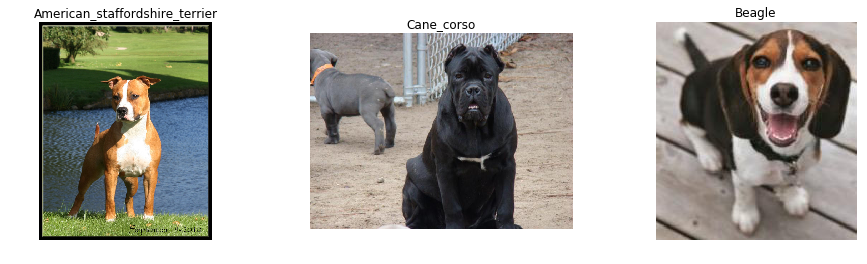





What's up DOG?!


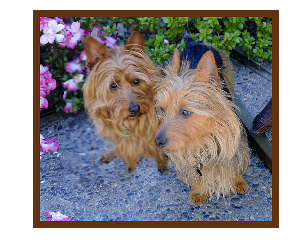

Actual Breed: Australian_terrier

Predicted Breed (confidence):
  - Australian_terrier (92%)
  - Norwich_terrier (4%)
  - Silky_terrier (2%)



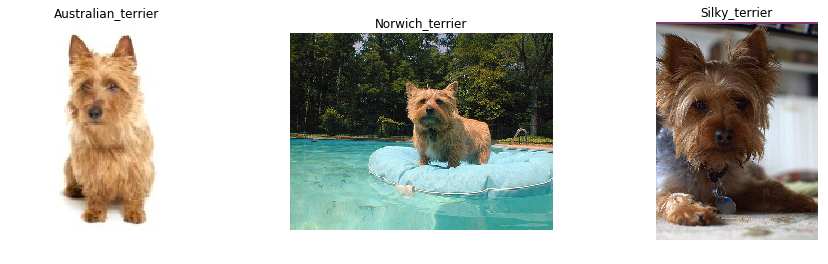





What's up DOG?!


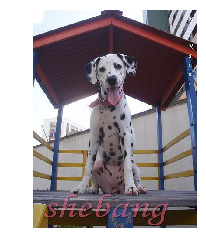

Actual Breed: Dalmatian

Predicted Breed (confidence):
  - Dalmatian (100%)



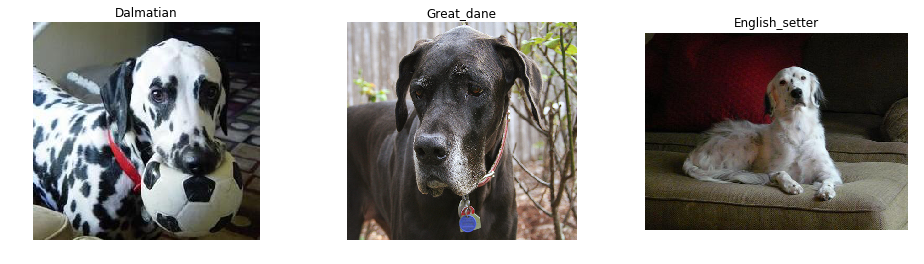

In [374]:
# Test algorithm on images provided in 'test' directory. Make predictions for each image. And show an example 
#  for each prediction.

display_predictions(test_img_paths[0:15])

We can see from the results above that the predictions are quite accurate, with a few breeds being correctly predicted with 100% confidence. However, the model still struggles to differentiate certain breeds, such as Beagle vs American Foxhound.

---
<a id='step5'></a>
## Step 5:  Incorporate Model into Human-Dog Detection Algorithm

## Notes

1. When you encounter this error, `RuntimeError: cuda runtime error (59) : device-side assert triggered` you may have a mismatch in the expected number of classes (i.e. the number of output nodes in your last fc layer must equal the number of classes in your target data). Once you correct this in the code, you need to restart the kernel and re-run all of the notebook cells. [Here is a link](https://medium.com/@nokkk/notes-for-some-stupid-error-that-i-made-with-pytorch-721ad0397436) describing the issue. 